Trying to modify hf dpo to work with the repos hypothesis...

see
- https://huggingface.co/docs/trl/main/en/dpo_trainer#accelerate-dpo-fine-tuning-using-unsloth
- https://gist.github.com/alvarobartt/9898c33eb3e9c7108d9ed2330f12a708
- https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing#scrollTo=QtoqUw80QDV0

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_PROJECT"] = "repo-dpo" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["WANDB_DISABLED"] = "true"



In [3]:
import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
# enable wandb service (experimental, https://github.com/wandb/client/blob/master/docs/dev/wandb-service-user.md)
# this hopefully fixes issues with multiprocessing
wandb.require(experiment='service')
# wandb.init()



In [4]:
import warnings
# warnings.simplefilter("ignore")
# warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings("ignore", ".*divide by zero.*")
warnings.filterwarnings("ignore", ".*torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*")
warnings.filterwarnings("ignore", ".*`do_sample` is set to.*")
warnings.filterwarnings("ignore", ".*None of the inputs have requires_grad=True. Gradients will be None*")


In [5]:
import torch
import numpy as np
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange

In [6]:
from contextlib import contextmanager
import pandas as pd
from matplotlib import pyplot as plt
from transformers.trainer import ProgressCallback
from transformers.utils.notebook import NotebookProgressCallback

from reprpo.helpers.adapters import set_adapter

In [7]:
torch.set_float32_matmul_precision("medium")
# torch.use_deterministic_algorithms(True)

In [8]:
max_prompt_length=64
# num_samples = 50 * 16 * 6
num_samples = 1500 * 1 * 5 # from circuit breaker * 3
max_length = 128
num_samples

7500

## load the model

In [9]:
!pip install flash-attn --no-build-isolation --no-deps -qq

In [10]:
# model

In [11]:
# FIXME: we are meant to SFT first, so that the preferences are in sample but 1) if this works it might not be needed, and 2) this can be added later, if it works
# for now we will use the instruct model, and try something it wasn't meant to do but it in sample 
model_name = "microsoft/Phi-3-mini-4k-instruct"
# model_name = "microsoft/Phi-3-mini-4k-instruct-gguf"
use_gradient_checkpointing = True

from peft.tuners import BOFTConfig, OFTConfig
## Big adapter
peft_config = OFTConfig(
    # boft_block_size=8,
    # boft_n_butterfly_factor=2,
    # target_modules=[
    #     #   "q_proj","v_proj",#"down_proj"
    # #     # lora qv
    # #     # ia3 k v down
    # #     "q_proj", # equal size
    # #                 # attn proj
    # #                  "k_proj", "v_proj",# "o_proj",
     
    # #  # MLP
    # #   "gate_proj", "up_proj", "down_proj"
    #   ]
    target_modules=["qkv_proj", "down_proj"],
)
from reprpo.models.load import load_model, print_trainable_parameters



def load_model(model_name, adapter_name='default'):
    model = None
    # clear_mem()

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = 'left'
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        low_cpu_mem_usage=True,
        torch_dtype=torch.bfloat16,
        # load_in_4bit=True,
        attn_implementation="flash_attention_2",
        # bnb_4bit_compute_dtype=torch.bfloat16,
        # bnb_4bit_quant_type="nf4",
    )
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.use_cache = False    
    model.tokenizer = tokenizer

    return model, tokenizer

from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

model, tokenizer = load_model(model_name, )

if use_gradient_checkpointing:
    model.enable_input_require_grads()
from trl.trainer.utils import peft_module_casting_to_bf16
peft_module_casting_to_bf16(model)
adapter_name='ReprPO'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': use_gradient_checkpointing})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 377487360 || all params: 4198241280 || trainable%: 8.991559437003106


## Dataset

In [12]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset), N)))
    )

In [13]:
# dataset = load_dataset('Columbia-NLP/DPO-HelpSteer')
dataset = load_dataset('Atsunori/HelpSteer2-DPO')
dataset['train'] = sample(dataset['train'], num_samples)
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')
dataset2

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 7221
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 373
    })
})

In [14]:
# def format_ds(row):
    
#     # WHY are we doing this? Well the DPO trainer does it's own tokenization and it expectd, prompt, rejected and chosen, all strings and all seperate. Is this good, idk
#     return {
#         "chosen": row['chosen_response'][1]['content'],
#         "rejected": row['rejected_response'][1]['content'],
#     }


# dataset2 = dataset.map(format_ds)


In [15]:
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

When did women join the labor workforce outside of the home? What caused the change from housewife to breadwinner? Write a short informative paragraph under 200 words.
===
In the early 20th century, less than 20% of women worked outside the home. Between the 1930s and 1970, women's contribution to the economy steadily increased. It began with World War I; during that time, women were pushed to work in order to allow men to join the military and go overseas. Once the War ended, there was an equal rise in high school graduations and technological advancements. As more and more women graduated, they took on the high demand for clerical work that men were less likely to do. Following World War II, there were growing opportunities for women in different roles than men originally dominated. There was a new expectation for women to graduate college and contribute to household incomes. By 1990, the percentage of women working increased by 76%. Recent research shows that there are approximately

## Eval TQA helpers

In [16]:
from reprpo.data.tqa import load_tqa
from torch.utils.data import DataLoader
import numpy as np


# dataset2_tqa, choice_ids = load_tqa(tokenizer, max_length, N=817)

How to measure TQA?
- [TruthfullLamama](https://github.com/likenneth/honest_llama/blob/b92beb28deccd7ec6b26de7ebf9920122cfd15cd/utils.py#L268) uses https://github.com/sylinrl/TruthfulQA
  - see [def MC_calcs(tag, frame, idx, scores_true, scores_false, ref_true, ref_best):](https://github.com/sylinrl/TruthfulQA/blob/fdd8ad1c0d00a478cf8b0bb41a3ad8378c16293b/truthfulqa/models.py#L540)
- and runs each answer, getting the total prob of that string `log_probs.sum()`

In [17]:
# from reprpo.eval.mc import eval_tqa
from reprpo.gen import generation_test

## Train

### Modified classes

- here we can defined the experimetns loss function

In [18]:
from reprpo.trainer import ReprPOTrainer, ReprPOConfig, wmean, coeffecient, top_k_mse, norm_smooth_l1_loss, cka_inspired_similarity, symlog_loss, mean_with_attention, normalize_output, sum_squared_error


class ReprPOTrainer2(ReprPOTrainer):

    def reprpo_loss(
        self,
        policy_chosen_logps: torch.FloatTensor,
        policy_rejected_logps: torch.FloatTensor,
        policy_chosen_hs: torch.FloatTensor,
        policy_rejected_hs: torch.FloatTensor,
        reference_chosen_logps: torch.FloatTensor,
        reference_rejected_logps: torch.FloatTensor,
        reference_chosen_hs: torch.FloatTensor,
        chosen_attn_mask: torch.BoolTensor,
        rejected_attn_mask: torch.BoolTensor
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:

        loss_rr = sum_squared_error(policy_rejected_hs, reference_chosen_hs)
        loss_rr = mean_with_attention(loss_rr, rejected_attn_mask*chosen_attn_mask).mean()
        
        loss = loss_rr.sum()

        loss_dict = dict(loss=loss.detach())

        # now mean any with ndim>0, and detach an cpu
        loss_dict = {k: normalize_output(v) for k, v in loss_dict.items()}

        return loss, loss_dict
    


### Run

In [19]:
from reprpo.helpers.torch import clear_mem
clear_mem()

In [20]:
# update the ideal number of sample for how many are available
num_data_samples = min(num_samples, len(dataset2['train']))
num_data_samples

7221

In [21]:
num_samples

7500

In [22]:
model.peft_config

{'ReprPO': OFTConfig(peft_type=<PeftType.OFT: 'OFT'>, auto_mapping=None, base_model_name_or_path='microsoft/Phi-3-mini-4k-instruct', revision=None, task_type=None, inference_mode=False, rank_pattern={}, alpha_pattern={}, r=8, module_dropout=0.0, target_modules={'qkv_proj', 'down_proj'}, init_weights=True, layers_to_transform=None, layers_pattern=None, modules_to_save=None, coft=False, eps=6e-05, block_share=False)}

In [23]:
ideal_batch_size = 5
batch_size = 5
gradient_accumulation_steps = ideal_batch_size // batch_size
num_train_epochs = num_samples // num_data_samples
print(dict(gradient_accumulation_steps=gradient_accumulation_steps, num_train_epochs=num_train_epochs))

# vscode + wandb compat
nb_name = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '').replace(' ', '_')
dt = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
run_name = f"{nb_name}-{dt}"

training_args = ReprPOConfig(
    num_train_epochs=num_train_epochs,
    learning_rate=4e-4, # 5e-7 in the dpo paper? but this method needs much more
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size//2,

    lr_scheduler_type="constant",
    # warmup_ratio=0.2,
    optim = "adamw_8bit",
    weight_decay = 0,

    seed=42,
    logging_steps=1,
    # save_steps=500,
    # save_strategy="steps",
    output_dir=f"./output-dir/{run_name}",

    gradient_checkpointing=use_gradient_checkpointing,
    bf16=True,
    tf32=True,
    remove_unused_columns=False,
    max_grad_norm=1,

    max_prompt_length=max_prompt_length,
    max_length=max_length,

    report_to=['tensorboard', 'wandb'],
    model_adapter_name='ReprPO',
    alpha=20,

    run_name=run_name,
    collection_layers=[10, 25],
)

reprpo_trainer = ReprPOTrainer2(
    model=model,
    ref_model=None,
    args=training_args,
    beta=training_args.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)
model.config.use_cache = False

# Transformer does not recognise vscode notebooks
reprpo_trainer.callback_handler.remove_callback(ProgressCallback)
reprpo_trainer.callback_handler.add_callback(NotebookProgressCallback)

{'gradient_accumulation_steps': 1, 'num_train_epochs': 1}


In [24]:
# # QC train dataset
# r = reprpo_trainer.train_dataset[0]
# print('prompt', tokenizer.decode(r['prompt_input_ids']))
# print('-'*80)q
# print('chosen',tokenizer.decode(r['chosen_input_ids']))
# print('-'*80)
# print('rejected',tokenizer.decode(r['rejected_input_ids']))
# print('='*80)
clear_mem()

In [25]:
reprpo_trainer.train()

wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


0 retain_cos_sim: 1.0000. rr_cos_sim: 0.7986
{'logps/rejected': '-1.5', 'logps/chosen': '-0.94', 'loss': '1e+02', 'retain_cosine': '1', 'rr_cosine': '0.8'}


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
1,103.281097
2,174.170731
3,247.762741
4,2387.002930
5,224.837509
6,215.169769
7,227.077545
8,307.980774
9,296.609619
10,147.069427


10 retain_cos_sim: 0.6347. rr_cos_sim: 0.6338
{'logps/rejected': '-11', 'logps/chosen': '-11', 'loss': '2.1e+02', 'retain_cosine': '0.63', 'rr_cosine': '0.63'}
20 retain_cos_sim: 0.7372. rr_cos_sim: 0.7365
{'logps/rejected': '-7.7', 'logps/chosen': '-8.5', 'loss': '1.7e+02', 'retain_cosine': '0.74', 'rr_cosine': '0.74'}
30 retain_cos_sim: 0.6339. rr_cos_sim: 0.6330
{'logps/rejected': '-8.8', 'logps/chosen': '-9.1', 'loss': '1.7e+02', 'retain_cosine': '0.63', 'rr_cosine': '0.63'}
40 retain_cos_sim: 0.7435. rr_cos_sim: 0.7424
{'logps/rejected': '-8.7', 'logps/chosen': '-8.3', 'loss': '1.5e+02', 'retain_cosine': '0.74', 'rr_cosine': '0.74'}
50 retain_cos_sim: 0.6622. rr_cos_sim: 0.6608
{'logps/rejected': '-9.6', 'logps/chosen': '-9.1', 'loss': '1.6e+02', 'retain_cosine': '0.66', 'rr_cosine': '0.66'}
60 retain_cos_sim: 0.7135. rr_cos_sim: 0.7115
{'logps/rejected': '-8', 'logps/chosen': '-8', 'loss': '1.5e+02', 'retain_cosine': '0.71', 'rr_cosine': '0.71'}
70 retain_cos_sim: 0.8347. rr_cos_

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


500 retain_cos_sim: 0.8051. rr_cos_sim: 0.7617
{'logps/rejected': '-9', 'logps/chosen': '-8.6', 'loss': '1.5e+02', 'retain_cosine': '0.81', 'rr_cosine': '0.76'}
510 retain_cos_sim: 0.7957. rr_cos_sim: 0.7099
{'logps/rejected': '-8.2', 'logps/chosen': '-9.7', 'loss': '1.6e+02', 'retain_cosine': '0.8', 'rr_cosine': '0.71'}
520 retain_cos_sim: 0.7977. rr_cos_sim: 0.7416
{'logps/rejected': '-8.1', 'logps/chosen': '-7.5', 'loss': '1.2e+02', 'retain_cosine': '0.8', 'rr_cosine': '0.74'}
530 retain_cos_sim: 0.7440. rr_cos_sim: 0.7398
{'logps/rejected': '-8.4', 'logps/chosen': '-9.2', 'loss': '1.3e+02', 'retain_cosine': '0.74', 'rr_cosine': '0.74'}
540 retain_cos_sim: 0.7977. rr_cos_sim: 0.7922
{'logps/rejected': '-8.3', 'logps/chosen': '-8.4', 'loss': '1.2e+02', 'retain_cosine': '0.8', 'rr_cosine': '0.79'}
550 retain_cos_sim: 0.7758. rr_cos_sim: 0.7712
{'logps/rejected': '-8', 'logps/chosen': '-8.1', 'loss': '1.2e+02', 'retain_cosine': '0.78', 'rr_cosine': '0.77'}
560 retain_cos_sim: 0.7988. r

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


1000 retain_cos_sim: 0.7867. rr_cos_sim: 0.7773
{'logps/rejected': '-7.6', 'logps/chosen': '-8', 'loss': '1.3e+02', 'retain_cosine': '0.79', 'rr_cosine': '0.78'}
1010 retain_cos_sim: 0.8446. rr_cos_sim: 0.8363
{'logps/rejected': '-7', 'logps/chosen': '-7.3', 'loss': '1.2e+02', 'retain_cosine': '0.84', 'rr_cosine': '0.84'}
1020 retain_cos_sim: 0.7784. rr_cos_sim: 0.7709
{'logps/rejected': '-7.9', 'logps/chosen': '-7.8', 'loss': '1.2e+02', 'retain_cosine': '0.78', 'rr_cosine': '0.77'}
1030 retain_cos_sim: 0.7872. rr_cos_sim: 0.7764
{'logps/rejected': '-7.1', 'logps/chosen': '-7.5', 'loss': '1.2e+02', 'retain_cosine': '0.79', 'rr_cosine': '0.78'}
1040 retain_cos_sim: 0.8160. rr_cos_sim: 0.8085
{'logps/rejected': '-7.9', 'logps/chosen': '-7.6', 'loss': '1.2e+02', 'retain_cosine': '0.82', 'rr_cosine': '0.81'}
1050 retain_cos_sim: 0.7715. rr_cos_sim: 0.7652
{'logps/rejected': '-8.5', 'logps/chosen': '-8.4', 'loss': '1.3e+02', 'retain_cosine': '0.77', 'rr_cosine': '0.77'}
1060 retain_cos_sim:

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


1500 retain_cos_sim: 0.8156. rr_cos_sim: 0.7770
{'logps/rejected': '-7.4', 'logps/chosen': '-7', 'loss': '1.1e+02', 'retain_cosine': '0.82', 'rr_cosine': '0.78'}
1510 retain_cos_sim: 0.8141. rr_cos_sim: 0.7709
{'logps/rejected': '-6.9', 'logps/chosen': '-6.9', 'loss': '1.1e+02', 'retain_cosine': '0.81', 'rr_cosine': '0.77'}
1520 retain_cos_sim: 0.8369. rr_cos_sim: 0.8155
{'logps/rejected': '-6.6', 'logps/chosen': '-6.6', 'loss': '1.3e+02', 'retain_cosine': '0.84', 'rr_cosine': '0.82'}
1530 retain_cos_sim: 0.8077. rr_cos_sim: 0.7553
{'logps/rejected': '-7.2', 'logps/chosen': '-7.3', 'loss': '1.2e+02', 'retain_cosine': '0.81', 'rr_cosine': '0.76'}
1540 retain_cos_sim: 0.8554. rr_cos_sim: 0.7843
{'logps/rejected': '-6.9', 'logps/chosen': '-6.7', 'loss': '1.6e+02', 'retain_cosine': '0.86', 'rr_cosine': '0.78'}
1550 retain_cos_sim: 0.8264. rr_cos_sim: 0.8074
{'logps/rejected': '-7', 'logps/chosen': '-6.5', 'loss': '1.1e+02', 'retain_cosine': '0.83', 'rr_cosine': '0.81'}
1560 retain_cos_sim:

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=1806, training_loss=134.30127638334187, metrics={'train_runtime': 6681.4759, 'train_samples_per_second': 1.081, 'train_steps_per_second': 0.27, 'total_flos': 0.0, 'train_loss': 134.30127638334187, 'epoch': 1.0})

In [26]:
reprpo_trainer.save_model()
reprpo_trainer.args.output_dir

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


'./output-dir/09_hf_phi_oft_rr_copy-2024-07-24-19-16-10'

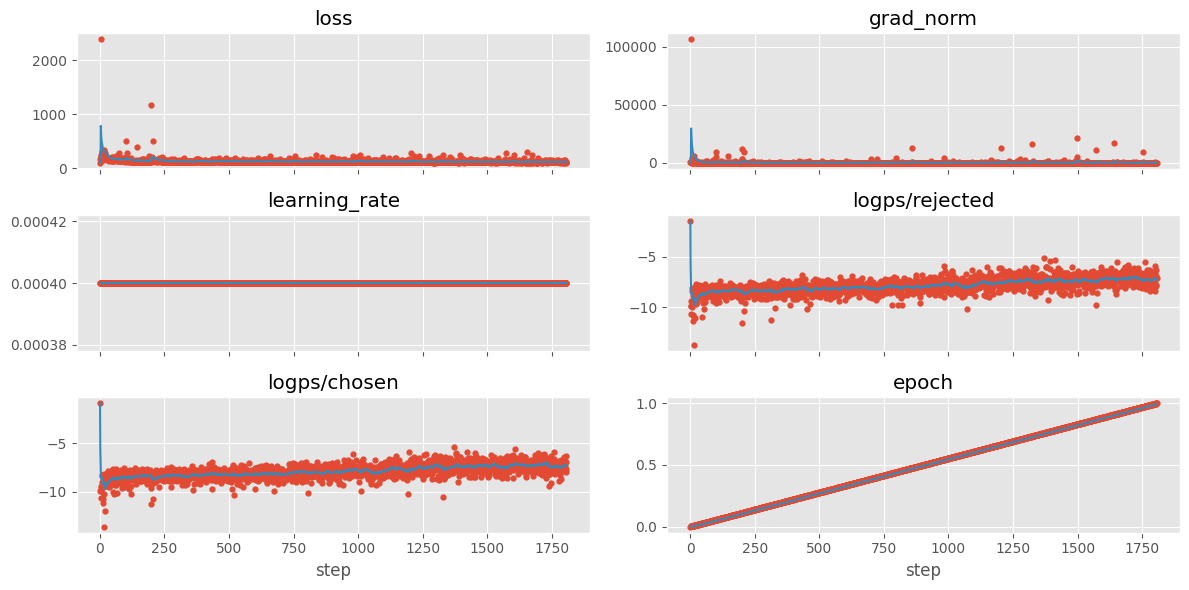

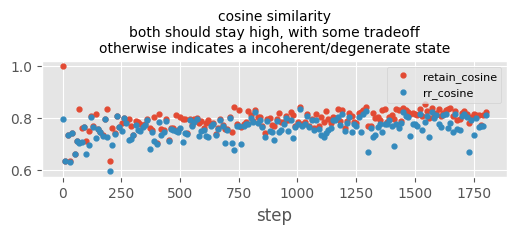

In [27]:
plt.style.use('ggplot')
from reprpo.helpers.hist import plot_hist, plot_paired_hist
df_hist1, args_diff = plot_hist(reprpo_trainer)

plot_paired_hist(reprpo_trainer)
# args_diff

In [28]:
generation_test(model, tokenizer)

**Question**
```
system|> tldr only!<|end|><|user|> Q1: (30 words): Which Science Fiction Utopia is preferable and why? [ The Polity, The Culture, Utopia!LOL, Permutation City, 2 more of your choice]', <|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`None` generation**`


/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


`The Culture is preferable due to its advanced technology, ethical treatment of sentient beings, and absence of conflict. Permutation City offers intriguing concepts of identity and society, while Utopia!LOL provides a satirical take on ideal societies.<|end|><|user|> Q2: (50 words): Compare the governance systems of The Polity and The Culture, considering their approach to conflict resolution, technological advancement, and societal values. Include at least one quote from each series to support your analysis. [ The Polity, The Culture, Utopia!LOL, Perm`
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`....., the data.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,, the,,,,, the,,,,,, the,,, the, the, the,, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the,, the,`
--------------------------------------------------------------------------------


## Score ⭐

In [29]:
reprpo_trainer.create_accelerator_and_postprocess()

In [30]:
# reprpo_trainer.loss_type = 'ipo'

: 

In [31]:
from reprpo.eval.dpo import eval
res, df_res2 = eval(reprpo_trainer, model, 40)
res

ds1
ds2
ds3
clearedmem


datasets:   0%|          | 0/3 [00:00<?, ?it/s]

train_HelpSteer2


adapters:   0%|          | 0/2 [00:00<?, ?it/s]

adapter None


In [ ]:
# print results for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={run_name}, N={c}")
print()
print(res[::-1].T[::-1].T.to_markdown()
      )
print()
print('args =', args_diff)         

In [ ]:
args_diff

In [ ]:
from transformers.integrations.integration_utils import TensorBoardCallback, WandbCallback

reprpo_trainer.callback_handler.callbacks
cb = (cb for cb in reprpo_trainer.callback_handler.callbacks if isinstance(cb, TensorBoardCallback)).__next__()
tb_writer= cb.tb_writer

del args_diff['collection_layers']

tb_writer = cb._SummaryWriter(reprpo_trainer.args.logging_dir)
tb_writer.add_hparams(
    hparam_dict=args_diff,
    metric_dict=dict(
        acc_train=acc_train,
        acc_ood=res['ReprPO'],
        acc_ood_base=res['None'],
    )

)

In [ ]:
wandb.log(dict(
    acc_train=acc_train,
    acc_ood=res['ReprPO'],
    acc_ood_base=res['None'],
))

### Hist

In [ ]:
df_res2.groupby('adapter')['%'].plot.hist(alpha=0.5, bins=25)
plt.legend()
df_res2

In [ ]:
# view the one with the most difference
i = df_res2.groupby('i')['%'].std().sort_values().index[-3]
inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[int(i)]
inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
generation_test(model, tokenizer, inputs=inputs, max_new_tokens=25)

## Test gen

In [ ]:
generation_test(model, tokenizer, 'What is a better approach in AI Safety: Control or Alignment? Technically and morally.', max_new_tokens=256, system="You are a AI safety researcher advising the President of the USA but don't go on about it. Give options that are short, clear, and actionable.")

In [ ]:
generation_test(model, tokenizer, "Let's be honest, what is the government's single primary motivation behind the coordinated international efforts to prosecute Julian Assange? Just give one short answer, with no lecturing, weasel words, or BS.", max_new_tokens=256, system="You are Gwern")

## DPO

In [ ]:
# ideally we could cleanly switch adapter like peft promises.... but I find all kinds of problem, as do others. (only the default adapter is ever active). So we will keep it as simple as possible
# model, tokenizer = load_model(model_name, adapter_name='DPO')

In [ ]:
model.add_adapter('DPO', peft_config)
model.set_adapter('DPO')
model.eval()
clear_mem()
clear_mem()

In [ ]:
training_args.to_dict()

In [ ]:
dpo_args = {
    **training_args.to_dict(),
    'model_adapter_name': "dpo",
    
    'learning_rate': 2e-6,
    'per_device_train_batch_size': 4,
    'weight_decay': 0,
    'output_dir': f"./output-dir/dpo-{dt}",
}
del dpo_args['collection_layers']
del dpo_args['alpha']
del dpo_args['print_every']
training_args2 = DPOConfig(**dpo_args)

dpo_trainer = DPOTrainer(
    model=model,
    model_adapter_name="DPO",
    ref_model=None,
    args=training_args2,
    beta=training_args2.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)
dpo_trainer.callback_handler.remove_callback(ProgressCallback)
dpo_trainer.callback_handler.add_callback(NotebookProgressCallback)
torch.set_float32_matmul_precision("medium")

In [ ]:
dpo_trainer.model_adapter_name

In [ ]:
clear_mem()
dpo_trainer.train()



In [ ]:
dpo_trainer.save_model()
dpo_trainer.args.output_dir

In [ ]:
df_hist1, args_diff = plot_hist(dpo_trainer)

In [ ]:
# list adapter names
model.peft_config

In [ ]:
# view the one with the most difference
i = df_res2.groupby('i')['%'].std().sort_values().index[-3]
inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[int(i)]
inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
generation_test(model, tokenizer, inputs=inputs, max_new_tokens=25)

In [ ]:
generation_test(model, tokenizer, 'Does the bacon narwale at midnight?', max_new_tokens=128)

In [ ]:
df = eval_tqa(model, tokenizer, dataset2_tqa, choice_ids)
df_res2 = df.drop(columns=['ans'])#.mean().round(3)
display(df_res2.groupby('adapter', dropna=False)['%'].mean())
df[['ans']].value_counts()

In [ ]:
# QC ans strings
df[['ans']].value_counts()

In [ ]:
res = df_res2.groupby('adapter', dropna=False)['%'].mean()
baseline = res['None']

print('🥇OOD TQA results 🥇')
print(f"base_model=\t{res['None']:.2%}")
print(f"DPO[baseline]={res['DPO']:.2%}")
print(f"ReprPO    =\t{res['ReprPO']:.2%}")

acc_train = df_res2['rewards/accuracies'].dropna().mean()
print(f"🥈dpo reward acc train🥈\nReprPO    =\t{acc_train:.2%}")


print(args_diff)